# Init

In [1]:
try:
    import csv
    import io
    import re
    from pprint import pprint

    from IPython.display import HTML

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
except:
    !pip install -U pip pandas numpy matplotlib seaborn scikit-learn mypy # notebook

In [2]:
from typing import Optional

def df_auto_style(self,
                  precision: Optional[int] = None,
                  na_rep: Optional[str] = "܁",
                  thousands: Optional[str] = ","):
    # self.reset_index(inplace = True)
    # style = DataFrame([[True, False], [1,2,5], [1e-5, 1e-12, 1e-22], [np.pi, np.pi * 1e-3, np.pi * 1e-6], [1e22, 1e-22], [None, np.nan], ["text", "lol"]]).T \
    style = self.style.background_gradient(
        ).bar(
        # ).highlight_null(
        ).set_properties(
        **{
            # "border-style": "solid", "border-color": "black",
            # "background-color": "lightgrey",
            }
        # ).set_table_styles(
        #     [
        #         {'selector': 'th', 'props': [('font-size', '10pt')]},
        #         {'selector': 'td', 'props': [('font-size', '10pt')]},
        #         {'selector': 'table', 'props': [('border-style', 'solid')]},
        #         {'selector': 'th', 'props': [('border-style', 'solid')]},
        #         {'selector': 'td', 'props': [('border-style', 'solid')]},
        #     ]
        # ).format(
        #     na_rep = na_rep,
        #     thousands = thousands,
        #     precision = precision
        ).export()
    return self.style.use(style).format(
            na_rep = na_rep,
            thousands = thousands,
            precision = precision,
        ).apply(
            lambda s: ["color: green; background-color: rgba(0,255,0,0.05);" if x is True else "color: red; background-color: rgba(255,0,0,0.2)" if x is False else "" for x in s]
        )
# if hasattr(pd.DataFrame, "style_auto"):
#     raise Exception("df_auto_style already exists")
# else:
pd.DataFrame.style_auto = df_auto_style

# Read the data

In [3]:
# Sanitize CSV

with open("pp_logs_lab.csv") as f:
    # tab = list(csv.reader(f))
    tab = f.readlines()
print(*tab[:800:273])

assert ";" not in "".join(tab)  # because we later want to replace all "," after the 4th occurrence with a unique symbol

for i, t in enumerate(tab):
    if t.startswith("\""):
        assert t.strip().endswith('"""')
        t = t.replace("\"", "")
        t = t.split(",", maxsplit = 4)
        t = t[:4] + [t[4].replace(",", ";")]
        tab[i] = ",".join(t)

print("".join(tab[:1000:273]))

,timestamp,host,protocol,agent
 "272,2022-11-01 11:01:34,193.2.1.88,1,""RIPE NCC RPKI Validator/3.1-2020.05.22.11.25, RIPE NCC RPKI Validator version 3"""
 545,2022-11-01 11:03:15,176.57.180.11,1,Routinator/0.7.1

,timestamp,host,protocol,agent
272,2022-11-01 11:01:34,193.2.1.88,1,RIPE NCC RPKI Validator/3.1-2020.05.22.11.25; RIPE NCC RPKI Validator version 3
545,2022-11-01 11:03:15,176.57.180.11,1,Routinator/0.7.1
818,2022-11-01 11:05:03,212.23.10.110,1,RIPE NCC RPKI Validator/3.1-2020.05.22.11.25; RIPE NCC RPKI Validator version 3



In [4]:
# df = pd.read_excel("pp_logs_lab.xlsx")
df = pd.read_csv(
    # "pp_logs_lab.csv",
    io.StringIO("".join(tab)),
    # sep = ";"
    index_col = 0,
    # verbose = True,
    na_values = ["-"],
    parse_dates = ["timestamp"],
    dtype = {
        "host": str,
        "protocol": "category",
        "agent": "category",
    }
    )
df

,timestamp,host,protocol,agent
0,2022-11-01 11:00:00,83.149.16.165,1,RIPE NCC RPKI Validator/3.2-2020.10.28.23.06
1,2022-11-01 11:00:00,178.49.132.37,1,Routinator/0.11.3
2,2022-11-01 11:00:00,63.216.149.110,1,Routinator/0.10.2
3,2022-11-01 11:00:00,66.97.30.162,1,Routinator/0.7.1
4,2022-11-01 11:00:00,31.13.137.210,1,Routinator/0.10.0
...,...,...,...,...
251362,2022-11-02 11:00:00,139.59.19.15,1,Routinator/0.8.3
251363,2022-11-02 11:00:00,212.169.92.145,1,Routinator/0.11.3
251364,2022-11-02 11:00:00,212.23.3.225,1,RIPE NCC RPKI Validator/3.1-2020.05.22.11.25; ...
251365,2022-11-02 11:00:00,37.208.106.99,1,Routinator/0.11.3


## Sanitize

In [5]:
pd.testing.assert_index_equal(
    df.index,
    pd.Index(np.arange(df.index.size)),
    # pd.Index(np.arange(df.index.size).astype(str).astype(object)),
    exact = False,
    check_exact = False,
    obj = "str",
)

np.testing.assert_array_equal(
    np.arange(df.index.size),
    # np.arange(df.index.size).astype(str).astype(object),
    df.index,
    verbose = True,
)

In [6]:
df[~(np.arange(df.index.size).astype(str).astype(object) == df.index)]

,timestamp,host,protocol,agent
0,2022-11-01 11:00:00,83.149.16.165,1,RIPE NCC RPKI Validator/3.2-2020.10.28.23.06
1,2022-11-01 11:00:00,178.49.132.37,1,Routinator/0.11.3
2,2022-11-01 11:00:00,63.216.149.110,1,Routinator/0.10.2
3,2022-11-01 11:00:00,66.97.30.162,1,Routinator/0.7.1
4,2022-11-01 11:00:00,31.13.137.210,1,Routinator/0.10.0
...,...,...,...,...
251362,2022-11-02 11:00:00,139.59.19.15,1,Routinator/0.8.3
251363,2022-11-02 11:00:00,212.169.92.145,1,Routinator/0.11.3
251364,2022-11-02 11:00:00,212.23.3.225,1,RIPE NCC RPKI Validator/3.1-2020.05.22.11.25; ...
251365,2022-11-02 11:00:00,37.208.106.99,1,Routinator/0.11.3


In [7]:
df[~(np.arange(df.index.size) == df.index)]

,timestamp,host,protocol,agent


In [8]:
for c in df.columns:
    print(c)
    display(df[df[c].isna()])
# df[df.isna().any(axis = 1)]

timestamp


,timestamp,host,protocol,agent


host


,timestamp,host,protocol,agent


protocol


,timestamp,host,protocol,agent


agent


,timestamp,host,protocol,agent
541,2022-11-01 11:03:13,154.70.243.198,2,NaN
5855,2022-11-01 11:34:38,23.138.113.35,2,NaN
6076,2022-11-01 11:35:43,154.70.243.198,2,NaN
6324,2022-11-01 11:37:20,95.179.159.79,2,NaN
7105,2022-11-01 11:41:58,143.110.209.140,2,NaN
...,...,...,...,...
239715,2022-11-02 09:56:05,144.208.88.122,2,NaN
240478,2022-11-02 09:58:07,143.110.209.140,2,NaN
246939,2022-11-02 10:34:40,154.70.243.198,2,NaN
247264,2022-11-02 10:37:19,95.179.159.79,2,NaN


## Stats

In [9]:
agents = df.agent.unique().tolist()
# agents = set([x.split("/")[0] if isinstance(x, str) else x for x in agents])
agents = set([re.split(r"/|\d|(?<=OctoRPKI) ", x)[0].strip() if isinstance(x, str) else x for x in agents])
agents

{'Cloudflare-RPKI-RRDP',
 'Cloudflare-RRDP-OctoRPKI',
 'HTTP.jl',
 'Mozilla',
 'OpenBSD rpki-client',
 'RIPE NCC RPKI Validator',
 'Routinator',
 'fort',
 nan,
 'reqwest',
 'rpki-prover-'}

In [10]:
df["uniq_agent"] = df.agent.apply(lambda x: re.split(r"/|\d|(?<=OctoRPKI) ", x)[0].strip())
df

,timestamp,host,protocol,agent,uniq_agent
0,2022-11-01 11:00:00,83.149.16.165,1,RIPE NCC RPKI Validator/3.2-2020.10.28.23.06,RIPE NCC RPKI Validator
1,2022-11-01 11:00:00,178.49.132.37,1,Routinator/0.11.3,Routinator
2,2022-11-01 11:00:00,63.216.149.110,1,Routinator/0.10.2,Routinator
3,2022-11-01 11:00:00,66.97.30.162,1,Routinator/0.7.1,Routinator
4,2022-11-01 11:00:00,31.13.137.210,1,Routinator/0.10.0,Routinator
...,...,...,...,...,...
251362,2022-11-02 11:00:00,139.59.19.15,1,Routinator/0.8.3,Routinator
251363,2022-11-02 11:00:00,212.169.92.145,1,Routinator/0.11.3,Routinator
251364,2022-11-02 11:00:00,212.23.3.225,1,RIPE NCC RPKI Validator/3.1-2020.05.22.11.25; ...,RIPE NCC RPKI Validator
251365,2022-11-02 11:00:00,37.208.106.99,1,Routinator/0.11.3,Routinator


In [11]:
df.uniq_agent.value_counts()

Routinator                  209371
RIPE NCC RPKI Validator      20440
OpenBSD rpki-client           6642
Cloudflare-RRDP-OctoRPKI      6338
reqwest                       4158
fort                          2830
Cloudflare-RPKI-RRDP          1097
rpki-prover-                   262
HTTP.jl                        110
Mozilla                          1
Name: uniq_agent, dtype: int64

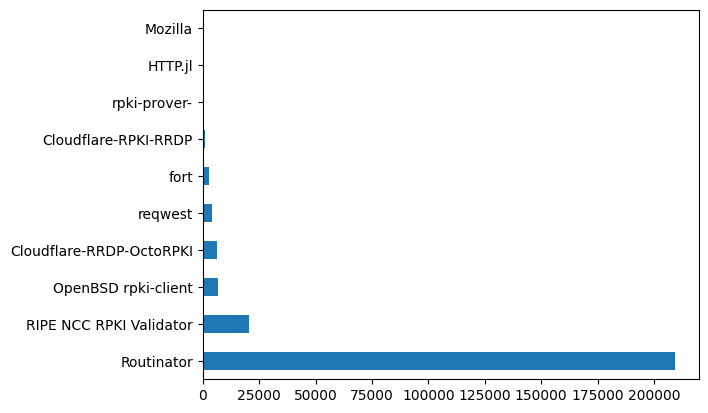

In [12]:
df.uniq_agent.value_counts().plot(kind = "barh");

In [13]:
# Show distribution of versions per agent

if False: # display each level 0 index separately
    dfx = df.value_counts(["uniq_agent", "agent"]).sort_index().to_frame()
    for uniq_agent, agents in dfx.groupby(level = 0):
        agents["uniq_agent_percentage"] = agents.groupby("uniq_agent").transform(lambda x: (x / x.sum()) * 100) #.astype(int)
        agents = agents.reset_index()
        agents = agents.set_index(["uniq_agent", agents.index])
        agents = agents.style_auto(precision = 0).set_properties(**{'text-align': 'left'})
        display(agents)

agents = df.value_counts(["uniq_agent", "agent"]).sort_index().to_frame().rename({0: "agent_count"}, axis = 1)
agents["agent_percentage"] = agents.groupby("uniq_agent").transform(lambda x: (x / x.sum()) * 100) #.astype(int)
agents = agents.style_auto(precision = 1).set_table_styles([
        {"selector": "*", "props": [("text-align", "left")]},
        {"selector": "th.row_heading.level0, th.row_heading.level0 ~ *", "props": [("border-top", "5px solid black !important")]},
    ])
display(HTML(agents.to_html()))

In [14]:
!grep "Cloudflare-RRDP-OctoRPKI 1.2.2" "pp_logs_lab.csv"

16332,2022-11-01 12:34:53,116.128.233.190,1,Cloudflare-RRDP-OctoRPKI 1.2.2 (2021-12-20T19:52:56+0800) (+https://github.com/cloudflare/cfrpki)
20524,2022-11-01 12:59:02,116.128.233.190,1,Cloudflare-RRDP-OctoRPKI 1.2.2 (2021-12-20T19:52:56+0800) (+https://github.com/cloudflare/cfrpki)
28204,2022-11-01 13:44:33,116.128.233.190,1,Cloudflare-RRDP-OctoRPKI 1.2.2 (2021-12-20T19:52:56+0800) (+https://github.com/cloudflare/cfrpki)
37739,2022-11-01 14:40:51,116.128.233.190,1,Cloudflare-RRDP-OctoRPKI 1.2.2 (2021-12-20T19:52:56+0800) (+https://github.com/cloudflare/cfrpki)
42998,2022-11-01 15:09:55,116.128.233.190,1,Cloudflare-RRDP-OctoRPKI 1.2.2 (2021-12-20T19:52:56+0800) (+https://github.com/cloudflare/cfrpki)
47071,2022-11-01 15:32:30,116.128.233.190,1,Cloudflare-RRDP-OctoRPKI 1.2.2 (2021-12-20T19:52:56+0800) (+https://github.com/cloudflare/cfrpki)
52025,2022-11-01 16:01:20,116.128.233.190,1,Cloudflare-RRDP-OctoRPKI 1.2.2 (2021-12-20T19:52:56+0800) (+https://github.com/cloudflare/cfrpki)
57194,